In [1]:
import os
import librosa
import numpy as np
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Dropout
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt

# 1. 資料加載與標記

In [23]:
import random
from tqdm import tqdm
from data_preprocess import extract_features

def augment_audio(audio, sr):
    # 隨機添加背景噪聲
    noise = np.random.randn(len(audio))
    audio_noisy = audio + 0.005 * noise

    # 隨機裁剪
    if len(audio_noisy) > int(sr * 2):
        start = random.randint(0, len(audio_noisy) - int(sr * 2))
        audio_cropped = audio_noisy[start:start + int(sr * 2)]
    else:
        audio_cropped = audio_noisy

    return audio_cropped

def load_normal_files(directory):
    """
    載入目錄中所有正常（no-leak）音訊檔案。

    Args:
        directory (str): 音訊檔案所在的目錄。

    Returns:
        list: 正常音訊資料的列表，每個元素為 (音訊資料, 取樣率, 檔案名稱)。
    """
    normal_files = []
    for dir in os.listdir(directory):
        if 'no-leak' not in dir:
            continue  # 只處理包含 'no-leak' 的目錄
        
        dir_path = os.path.join(directory, dir)
        if not os.path.isdir(dir_path):
            continue  # 確保是目錄
        
        for file in os.listdir(dir_path):
            if not file.endswith(".wav"):
                continue  # 只處理 .wav 檔案
            file_path = os.path.join(dir_path, file)
            y, sr = librosa.load(file_path, sr=None)
            y = augment_audio(y, sr)  # 應用資料增強
            filename = f'{dir}_{file}'
            normal_files.append((y, sr, filename))
    
    return normal_files

def create_normal_dataset(directory, desired_time=2.0, n_mels=128, n_fft=2048, hop_length=512):
    """
    載入並預處理正常（no-leak）音訊資料。

    Args:
        directory (str): 音訊檔案所在的目錄。
        desired_time (float): 每個樣本的目標時間長度（秒）。
        n_mels (int): Mel 頻帶數。
        n_fft (int): FFT 大小。
        hop_length (int): hop length。

    Returns:
        np.ndarray: 預處理後的特徵資料，形狀為 (樣本數, max_len, n_mels, 1)。
    """
    normal_files = load_normal_files(directory)
    
    print(f"總正常樣本數: {len(normal_files)}")
    
    features = []
    for audio, sr, filename in normal_files:
        feature = extract_features(audio, sr, n_mels=n_mels, n_fft=n_fft, hop_length=hop_length, desired_time=desired_time)
        features.append(feature)
    
    X = np.array(features)
    print(f"特徵形狀（未正規化）: {X.shape}")  # 預期形狀: (樣本數, max_len, n_mels)
    
    # 正規化特徵
    X = (X - np.mean(X)) / np.std(X)
    
    # 擴展維度以符合 Autoencoder 輸入 (樣本數, max_len, n_mels, 1)
    X = np.expand_dims(X, -1)
    print(f"特徵形狀（擴展後）: {X.shape}")  # 預期形狀: (樣本數, max_len, n_mels, 1)
    
    return X



# 3. 建立 Autoencoder 模型


In [12]:
from keras.layers import Flatten, Dense, Reshape
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Dropout
from tensorflow.keras.optimizers import Adam 

def combined_loss(y_true, y_pred):
    mse_loss = tf.keras.losses.mean_squared_error(y_true, y_pred)
    mae_loss = tf.keras.losses.mean_absolute_error(y_true, y_pred)
    return mse_loss + mae_loss

from tensorflow.keras.layers import BatchNormalization

def create_autoencoder(input_shape):
    input_img = Input(shape=input_shape)

    # 編碼器
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Dropout(0.3)(x)

    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Dropout(0.3)(x)

    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    encoded = MaxPooling2D((2, 2), padding='same')(x)
    x = Dropout(0.3)(encoded)
    
    # Flatten and Dense layers at bottleneck
    x = Flatten()(encoded)
    x = Dense(128, activation='relu')(x)
    x = Dense(64, activation='relu')(x)
    x = Dense(128, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dense(encoded.shape[1] * encoded.shape[2] * encoded.shape[3], activation='relu')(x)
    x = Reshape((encoded.shape[1], encoded.shape[2], encoded.shape[3]))(x)

    # 解碼器
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = UpSampling2D((2, 2))(x)
    x = Dropout(0.3)(x)

    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = UpSampling2D((2, 2))(x)
    x = Dropout(0.3)(x)

    x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = UpSampling2D((2, 2))(x)
    decoded = Conv2D(1, (3, 3), activation='linear', padding='same')(x)

    autoencoder = Model(input_img, decoded)
    autoencoder.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), loss='mse')

    return autoencoder





# 4. 訓練模型

In [13]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau


def train_autoencoder(autoencoder, X_train, epochs=50, batch_size=32, validation_split=0.1):
    """
    訓練 Autoencoder 模型。

    Args:
        autoencoder (tensorflow.keras.Model): 已建立的 Autoencoder 模型。
        X_train (np.ndarray): 訓練資料，形狀為 (樣本數, max_len, n_mels, 1)。
        epochs (int): 訓練輪數。
        batch_size (int): 批次大小。
        validation_split (float): 驗證集比例。

    Returns:
        tensorflow.keras.callbacks.History: 訓練歷史紀錄。
    """
    early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, min_lr=1e-6, verbose=1)
    history = autoencoder.fit(
        X_train, X_train,
        epochs=epochs,
        batch_size=batch_size,
        shuffle=True,
        validation_split=validation_split,
        verbose=2,
        callbacks=[early_stopping, reduce_lr]
    )
    return history

# 5. 繪製訓練過程

In [14]:
def plot_training_history(history):
    """
    繪製訓練過程中的損失曲線。

    Args:
        history (tensorflow.keras.callbacks.History): 訓練歷史紀錄。
    """
    plt.figure(figsize=(10, 4))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.legend()
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Autoencoder Training History')
    plt.show()


# 6. 使用 Autoencoder 進行異常檢測


In [22]:
def calculate_reconstruction_error(autoencoder, X):
    """
    計算每個樣本的重建誤差（MSE）。

    Args:
        autoencoder (tensorflow.keras.Model): 已訓練的 Autoencoder 模型。
        X (np.ndarray): 資料，形狀為 (樣本數, max_len, n_mels, 1)。

    Returns:
        np.ndarray: 每個樣本的 MSE，形狀為 (樣本數,)。
    """
    reconstructions = autoencoder.predict(X)
    mse = np.mean(np.power(X - reconstructions, 2), axis=(1,2,3))
    return mse

def determine_threshold(mse, percentile=95):
    """
    根據重建誤差的百分位數設定閾值。

    Args:
        mse (np.ndarray): 重建誤差，形狀為 (樣本數,)。
        percentile (float): 百分位數，用於設定閾值。

    Returns:
        float: 設定的閾值。
    """
    threshold = np.percentile(mse, percentile)
    return threshold

def predict_anomaly(mse, threshold):
    """
    根據重建誤差和閾值預測是否為異常。

    Args:
        mse (np.ndarray): 重建誤差，形狀為 (樣本數,)。
        threshold (float): 重建誤差閾值。

    Returns:
        np.ndarray: 預測標籤，1 表示異常，0 表示正常。
    """
    return (mse > threshold).astype(int)

def evaluate_model(y_true, y_pred):
    """
    評估模型的預測結果。

    Args:
        y_true (np.ndarray): 真實標籤，形狀為 (樣本數,)。
        y_pred (np.ndarray): 預測標籤，形狀為 (樣本數,)。

    """
    print("Confusion Matrix:")
    print(confusion_matrix(y_true, y_pred))
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred))

In [18]:
 # 訓練資料預處理（僅使用正常資料）
X_train = create_normal_dataset('training_data')
input_shape = (X_train.shape[1], X_train.shape[2], X_train.shape[3])
print(input_shape)

總正常樣本數: 10641
特徵形狀（未正規化）: (10641, 192, 128)
特徵形狀（擴展後）: (10641, 192, 128, 1)
(192, 128, 1)


In [19]:
# 建立 Autoencoder 模型
autoencoder = create_autoencoder(input_shape)
autoencoder.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 192, 128, 1)]     0         
                                                                 
 conv2d_7 (Conv2D)           (None, 192, 128, 32)      320       
                                                                 
 batch_normalization (BatchN  (None, 192, 128, 32)     128       
 ormalization)                                                   
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 96, 64, 32)       0         
 2D)                                                             
                                                                 
 dropout_5 (Dropout)         (None, 96, 64, 32)        0         
                                                                 
 conv2d_8 (Conv2D)           (None, 96, 64, 64)        1849

In [20]:
# 訓練 Autoencoder
history = train_autoencoder(autoencoder, X_train, epochs=150, batch_size=32, validation_split=0.1)

Epoch 1/150
300/300 [==============================] - 23s 72ms/step - loss: 0.4036 - val_loss: 0.9754 - lr: 1.0000e-04
Epoch 2/150
300/300 [==============================] - 21s 71ms/step - loss: 0.1276 - val_loss: 0.7367 - lr: 1.0000e-04
Epoch 3/150
300/300 [==============================] - 21s 71ms/step - loss: 0.0968 - val_loss: 0.6709 - lr: 1.0000e-04
Epoch 4/150
300/300 [==============================] - 21s 71ms/step - loss: 0.0831 - val_loss: 0.5586 - lr: 1.0000e-04
Epoch 5/150
300/300 [==============================] - 21s 71ms/step - loss: 0.0749 - val_loss: 0.5387 - lr: 1.0000e-04
Epoch 6/150
300/300 [==============================] - 22s 72ms/step - loss: 0.0704 - val_loss: 0.5815 - lr: 1.0000e-04
Epoch 7/150
300/300 [==============================] - 22s 72ms/step - loss: 0.0654 - val_loss: 0.5397 - lr: 1.0000e-04
Epoch 8/150
300/300 [==============================] - 22s 73ms/step - loss: 0.0619 - val_loss: 0.5942 - lr: 1.0000e-04
Epoch 9/150
300/300 [===================

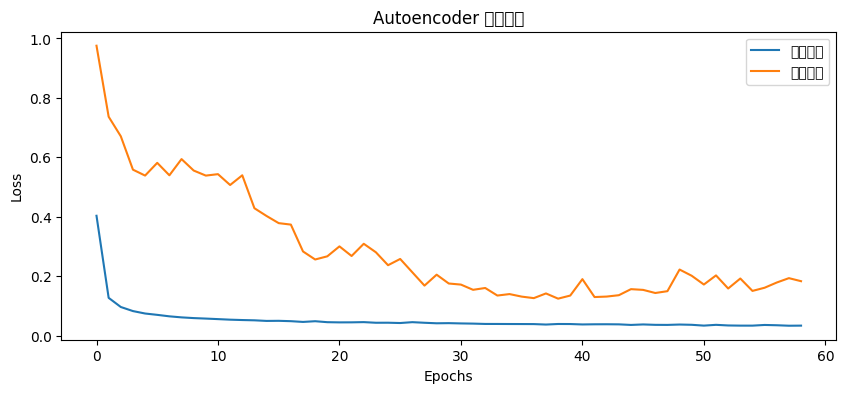

In [24]:
# 繪製訓練過程
plot_training_history(history)

In [26]:
# 保存 Autoencoder 模型
autoencoder.save('leak_detection_autoencoder.h5')
print("Autoencoder 模型已保存為 'leak_detection_autoencoder.h5'")

# 計算並設定閾值
mse_train = calculate_reconstruction_error(autoencoder, X_train)
threshold = determine_threshold(mse_train, percentile=95)
print(f"Autoencoder 重建誤差閾值設定為: {threshold}")

# 保存閾值
with open('autoencoder_threshold.txt', 'w') as f:
    f.write(str(threshold))
print("Autoencoder 閾值已保存為 'autoencoder_threshold.txt'")

Autoencoder 模型已保存為 'leak_detection_autoencoder.h5'


InternalError: Failed copying input tensor from /job:localhost/replica:0/task:0/device:CPU:0 to /job:localhost/replica:0/task:0/device:GPU:0 in order to run _EagerConst: Dst tensor is not initialized.

In [25]:
def load_test_files(directory, desired_time=2.0, n_mels=128, n_fft=2048, hop_length=512):
    """
    載入測試資料，包括正常和異常資料。
    """
    test_files = []
    y_test = []
    for dir in os.listdir(directory):
        if 'no-leak' in dir:
            label = 0
        else:
            label = 1
        dir_path = os.path.join(directory, dir)
        if not os.path.isdir(dir_path):
            continue
        for file in os.listdir(dir_path):
            if not file.endswith(".wav"):
                continue
            file_path = os.path.join(dir_path, file)
            y, sr = librosa.load(file_path, sr=None)
            y = augment_audio(y, sr)  # 應用資料增強
            feature = extract_features(
                y, sr, desired_time=desired_time, n_mels=n_mels, n_fft=n_fft, hop_length=hop_length
            )
            feature = (feature - np.mean(feature)) / np.std(feature)
            feature = np.expand_dims(feature, -1)  # (target_len, n_mels, 1)
            test_files.append(feature)
            y_test.append(label)
    
    X_test = np.array(test_files)
    print(f"測試資料形狀: {X_test.shape}")
    y_test = np.array(y_test)
    return X_test, y_test

In [ ]:
# 載入測試資料
X_test, y_test = load_test_files(
    'training_data', desired_time=2.0, n_mels=128, n_fft=2048, hop_length=512
)
# 計算重建誤差
mse_test = calculate_reconstruction_error(autoencoder, X_test)

# 預測異常
y_pred = predict_anomaly(mse_test, threshold)

# 評估模型
evaluate_model(y_test, y_pred)

# 繪製重建誤差分佈
plt.figure(figsize=(10,6))
plt.hist(mse_test[y_test == 0], bins=50, alpha=0.6, label='正常')
plt.hist(mse_test[y_test == 1], bins=50, alpha=0.6, label='異常')
plt.axvline(threshold, color='red', linestyle='dashed', linewidth=2, label='閾值')
plt.xlabel('重建誤差 (MSE)')
plt.ylabel('頻率')
plt.legend()
plt.title('重建誤差分佈')
plt.show()